In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

%reload_ext autoreload
%autoreload 2 

### Loading datasets

In [2]:
DATASET_NEMA_H0 = '../datasets/dataset_NEMA_NEMA_H0.csv'
DATASET_NEMA_H3 = '../datasets/dataset_NEMA_NEMA_H3.csv'
DATASET_NEMA_H15 = '../datasets/dataset_NEMA_NEMA_H15.csv'

In [3]:
from src.model.rc_dataset import ExperimentDataset


dataset_nema_h0 = ExperimentDataset(csv_path=DATASET_NEMA_H0)
dataset_nema_h3 = ExperimentDataset(csv_path=DATASET_NEMA_H3)
dataset_nema_h15 = ExperimentDataset(csv_path=DATASET_NEMA_H15)

datasets = [dataset_nema_h0, dataset_nema_h3, dataset_nema_h15]

### Target generator

In [4]:
from model_config_cnwheat import targets
from pipeline_cnwheat import TargetGenerator

target_generator = TargetGenerator(target=targets[0])
y_raw = target_generator.transform(datasets, warmup_days=4)

print(f'y_raw shape: {y_raw.shape}')

y_raw shape: (1, 2136)


### Reservoir generators

#### Homogeneous reservoirs

In [5]:
from model_config_cnwheat import state_variables
from pipeline_cnwheat import SingleReservoirGenerator


reservoir_generator = SingleReservoirGenerator(state_var=state_variables[2])
X_raw = reservoir_generator.transform(datasets, warmup_days=4)

print(f'X_raw shape: {X_raw.shape}')

X_raw shape: (1, 2136, 10)


#### Heterogeneous reservoirs

In [6]:
from pipeline_cnwheat import MultiReservoirGenerator


reservoir_generator = MultiReservoirGenerator(state_vars=state_variables)
X_raw = reservoir_generator.transform(datasets, warmup_days=4)

print(f'X_raw shape: {X_raw.shape}')

X_raw shape: (1, 2136, 122)


#### Environment baseline reservoirs

In [7]:
from model_config_cnwheat import input_targets
from pipeline_cnwheat import TargetReservoirGenerator


reservoir_generator = TargetReservoirGenerator(targets=input_targets)
X_raw = reservoir_generator.transform(datasets, warmup_days=4)

print(f'X_raw shape: {X_raw.shape}')

X_raw shape: (1, 2136, 3)


### Group generator

In [8]:
from pipeline_cnwheat import GroupGenerator


group_generator = GroupGenerator(day_length=24)

groups_raw = group_generator.transform(datasets, warmup_days=4)

print(f'Groups_raw shape: {groups_raw.shape}')
print(f'Unique groups: {len(np.unique(groups_raw))}')
print(groups_raw[0, 0:7*24:24])

Groups_raw shape: (1, 2136)
Unique groups: 33
[0. 1. 2. 3. 4. 5. 6.]


### Target transformers

#### Direct target (no transform)

In [9]:
from pipeline_base import DirectTarget

target_tf = DirectTarget()
y_tf = target_tf.transform(y_raw)

print(y_tf.shape)

(1, 2136)


### Reservoir transformers

#### Direct reservoir (no transform)

In [10]:
from pipeline_base import DirectReservoir


reservoir_tf = DirectReservoir()
X_tf = reservoir_tf.transform(X_raw)

print(X_tf.shape)

(1, 2136, 3)


### Flatten data

In [11]:
from pipeline_base import flatten

X, y, groups = flatten(X_tf, y_tf, groups_raw)

print(X.shape)
print(y.shape)
print(groups.shape)

(2136, 3)
(2136,)
(2136,)


### Data preprocessors

#### Daylight masking

In [23]:
from pipeline_base import DaylightMask


day_mask_tf = DaylightMask(day_length=24, start=5, end=21)
X_day, y_day, groups_day = day_mask_tf.transform(X, y, groups)

print(X_day.shape, y_day.shape, groups_day.shape)

(1424, 3) (1424,) (1424,)


#### Rescaling

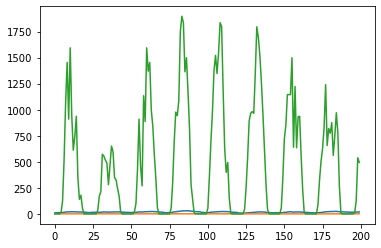

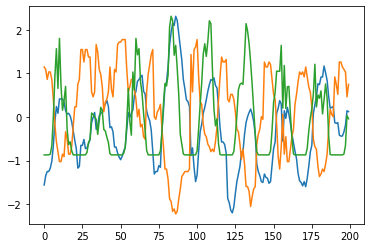

In [24]:
from pipeline_base import Rescale


plt.plot(X[:200])
plt.show()

scaler_tf = Rescale(per_feature=True)
X_scaled, _, _ = scaler_tf.transform(X, y, groups)

plt.plot(X_scaled[:200])
plt.show()

In [36]:
from pipeline_base import Preprocessor
from typing import List, Tuple


class GroupRescale(Preprocessor):
  "Rescale features based on the mean and std of the feature group they belong to."

  def __init__(self, *, datasets: List[ExperimentDataset], state_vars: List[str]):
    group_slices, n_features = self._get_groups(datasets, state_vars)
    self._group_slices = group_slices
    self._n_expected_features = n_features
    
  def _get_groups(self, datasets, state_vars) -> List[slice]:
    group_slices = [] 
    offset = 0
    for var in state_vars:
      res_generator = SingleReservoirGenerator(state_var=var)
      X_raw = res_generator.transform(datasets, warmup_days=0)
      group_size = X_raw.shape[-1]
      group_slices.append(slice(offset, offset + group_size))
      offset += group_size
    return group_slices, offset
    
  def transform(self, X, y, groups) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    for group_idx in self._group_slices:
      X_g = X[:, group_idx]
      X_g = (X_g - X_g.mean()) / X_g.std()
      X[:, group_idx] = X_g

    y = (y - y.mean()) / y.std()
    return X, y, groups



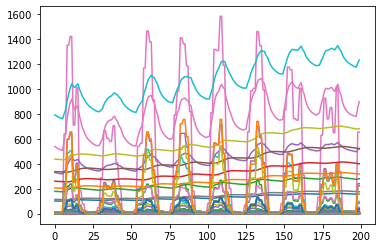

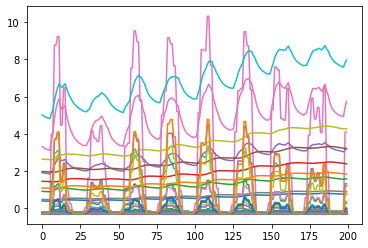

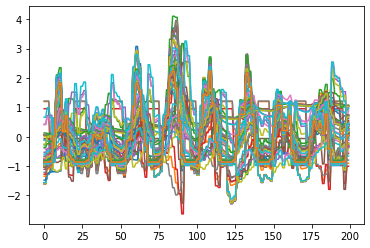

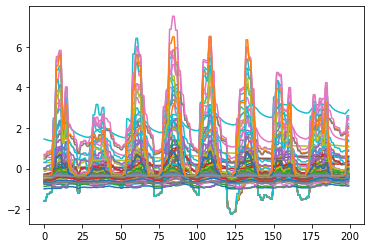

In [38]:
reservoir_generator = MultiReservoirGenerator(state_vars=state_variables)
X_raw = reservoir_generator.transform(datasets, warmup_days=4)
X, y, groups = flatten(X_raw, y_raw, groups_raw)

plt.plot(X[:200])
plt.show()

scaler = Rescale(per_feature=False)
X_, y_, groups_ = scaler.transform(X, y, groups)

plt.plot(X_[:200])
plt.show()

scaler = Rescale(per_feature=True)
X_, y_, groups_ = scaler.transform(X, y, groups)

plt.plot(X_[:200])
plt.show()

scaler = GroupRescale(datasets=datasets, state_vars=state_variables)
X_, y_, groups_ = scaler.transform(X, y, groups)

plt.plot(X_[:200])
plt.show()

### Train-test splitter

### Pipeline definition

In [132]:
from dataclasses import dataclass
from typing import Callable

from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator


BaseScorer = Callable[[BaseEstimator, np.ndarray, np.ndarray], float]

@dataclass
class RCPipeline:
  # Metadata (added as columns in the results dict)
  metadata: dict

  # Data generation
  datasets: List[ExperimentDataset]
  target: BaseTargetGenerator
  reservoir: BaseReservoirGenerator
  groups: BaseGroupGenerator

  # Data transformation
  warmup_days: int
  target_tf: TargetTransformer
  reservoir_tf: ReservoirTransformer

  # Data preproccessing
  preprocessing: List[Preprocessor]

  # Model
  train_test_split: BaseTrainTestSplitter
  readout_model: BaseEstimator
  model_param_grid: dict
  model_scorer: BaseScorer
  folds: BaseCrossValidator


##### Test example

In [144]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut

from src.learning.scorers import nmse_scorer

# Reservoir definition
reservoir_id = 'state__het_all'
reservoir = MultiReservoirGenerator(state_vars=state_variables)
reservoir_tf = DirectReservoir()

# Target definition
target_id = 'input_air_temperature'
target = TargetGenerator(target=target_id)
target_tf = DirectTarget()

# Model definition
readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e2), 50)
}]

pipeline = RCPipeline(
  # Metadata
  metadata={
    'target_id': target_id,
    'reservoir_id': reservoir_id,
    'dataset_id': 'NEMA_combined',
  },

  # Data generation
  datasets=datasets,
  target=target,
  reservoir=reservoir,
  groups=GroupGenerator(day_length=24),

  # Data transformation
  warmup_days=4,
  reservoir_tf=reservoir_tf,
  target_tf=target_tf,

  # Data preprocessing
  preprocessing=[
    DaylightMask(day_length=24, start=5, end=21),
    Rescale(per_feature=False)
  ],

  # Model training and testing
  train_test_split=TrainTestSplitter(block_size=4, test_ratio=0.5),
  readout_model=readout,
  model_param_grid=search_grid,
  model_scorer=nmse_scorer,
  folds=LeaveOneGroupOut(),
)

### Pipeline execution

In [174]:
from pipeline_base import execute_pipeline

results = execute_pipeline(pipeline)

print(results)

{'target_id': 'input_air_temperature', 'reservoir_id': 'state__het_all', 'dataset_id': 'NEMA_combined', 'test_score': -0.047169589011037065, 'train_mean': -0.038991294558955, 'train_std': 0.0029223571396617184, 'cv_mean': -0.20472957240013542, 'cv_std': 0.19331493044810283}
